In [41]:
import pandas as pd
import sklearn
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
import os

print(pd.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.5.1
1.1.3
0.13.5


## 1. 시계열 데이터 준비

In [42]:
import yfinance as yf
data = yf.download('005930.KS', start='2020-05-18', end='2021-05-18')
data.info()
# 인덱스 : Date
# 칼럼 종류: Open, High, Low, Close, Adj Close, Volume

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2020-05-18 to 2021-05-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       249 non-null    float64
 1   High       249 non-null    float64
 2   Low        249 non-null    float64
 3   Close      249 non-null    float64
 4   Adj Close  249 non-null    float64
 5   Volume     249 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.6 KB


In [43]:
# 종가 (Close)만 사용
ts = data['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## 2. 전처리 (결측치 처리, 로그 변환)

In [44]:
ts = ts.interpolate(method='time')
# https://rfriend.tistory.com/264
ts[ts.isna()] # 결측치가 없는 것을 확인!

Series([], Name: Close, dtype: float64)

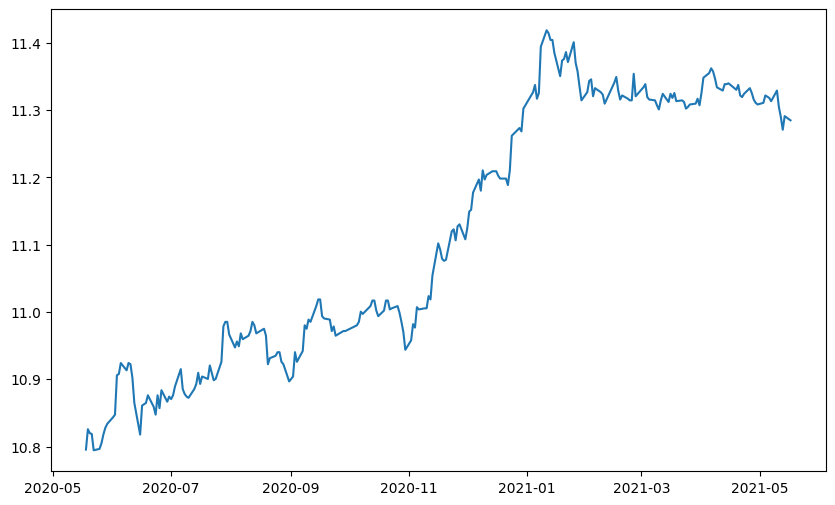

In [45]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## 3. 시계열 안정성 분석
1. 정성적 그래프 분석
2. 정량적 Augmented_Dicky_Fuller TextDisplayObject
3. 시계열 분해
4. Residual 안정성 확인

In [46]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [47]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    # adfuller method return result
    print("Results of ADFTest")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
                ...   
2021-05-11   -0.013218
2021-05-12   -0.025240
2021-05-13   -0.039022
2021-05-14   -0.015982
2021-05-17   -0.019667
Name: Close, Length: 249, dtype: float64

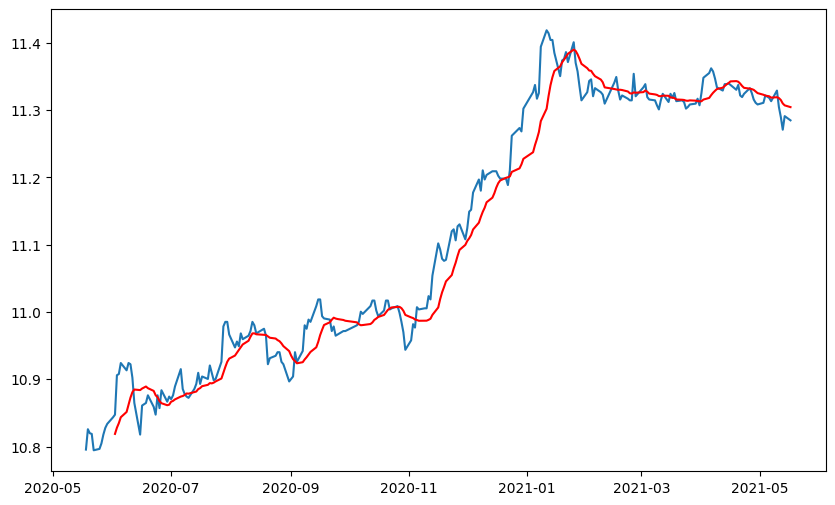

In [48]:
# Moving average 제거 - 추세(Trend) 상쇄
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

ts_moving_avg = ts_log - moving_avg
ts_moving_avg # 결측치 있음 (제거해야함!)

In [49]:
ts_moving_avg.dropna(inplace=True)
ts_moving_avg

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
                ...   
2021-05-11   -0.013218
2021-05-12   -0.025240
2021-05-13   -0.039022
2021-05-14   -0.015982
2021-05-17   -0.019667
Name: Close, Length: 238, dtype: float64

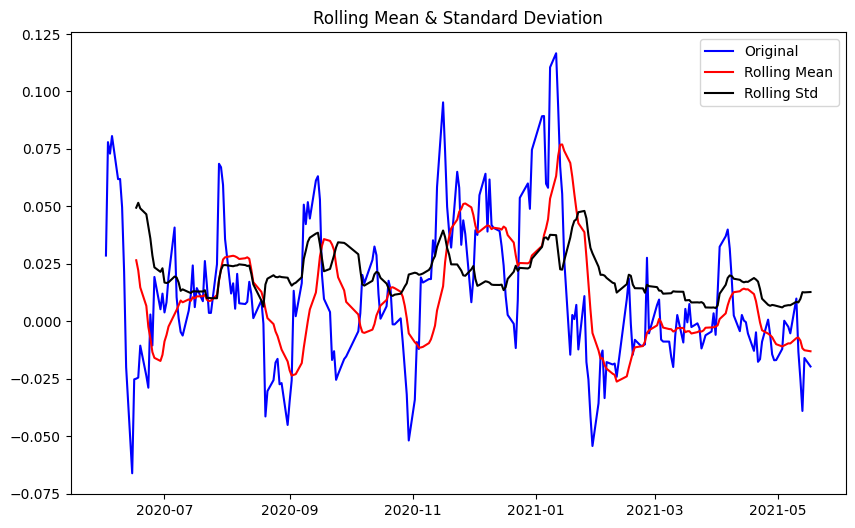

In [50]:
plot_rolling_statistics(ts_moving_avg)

In [51]:
augmented_dickey_fuller_test(ts_moving_avg)

Results of ADFTest
Test Statistic                  -4.153792
p-value                          0.000788
#Lags Used                       0.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


In [52]:
## 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 20) 
## ** 중요: period 설정 안하면 오류 남, time series에서 설정한 period의 주기에 따라 결정
# 시계열 데이터가 x의 인덱스에 빈도가 없는 경우 사용을 꼭 해줘야 함!
# https://dev.boombear.co.kr/entry/seasonaldecompose-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%84%ED%95%B4
# additive decomposition : 덧셈 분해
# multiplicative decomposition : 곱셈 분해
# 덧셈 분해는 Trend와 Seasonal이 별개, 곱셈 분해는 Trend에 따라 Seasonal이 변화

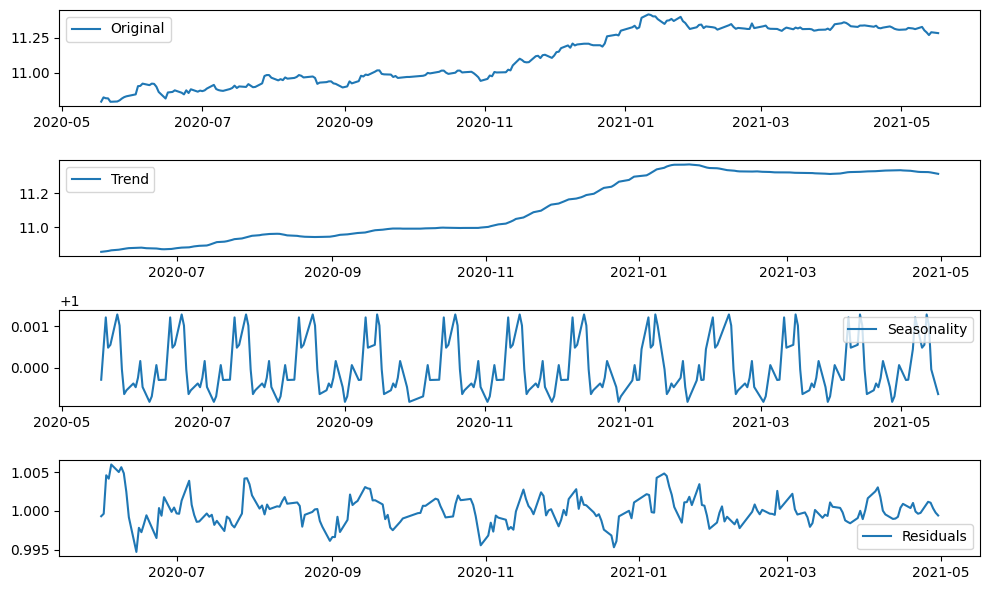

In [53]:
# 추세
trend = decomposition.trend 
# 계절성
seasonal = decomposition.seasonal
# 원본 - 추세 - 계절성 (데이터 분석에서는 Y_hat - Y)
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (10,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

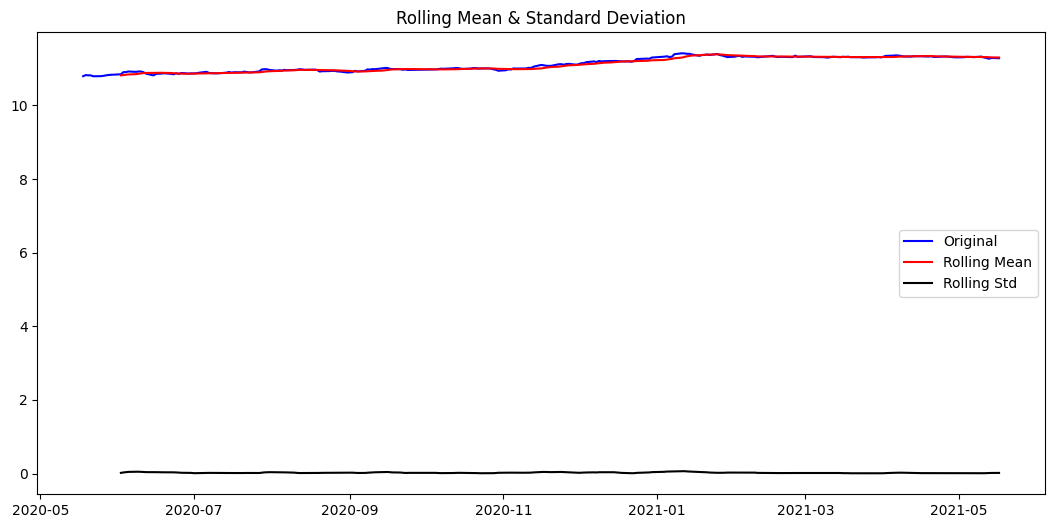

Results of ADFTest
Test Statistic                  -1.376439
p-value                          0.593518
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


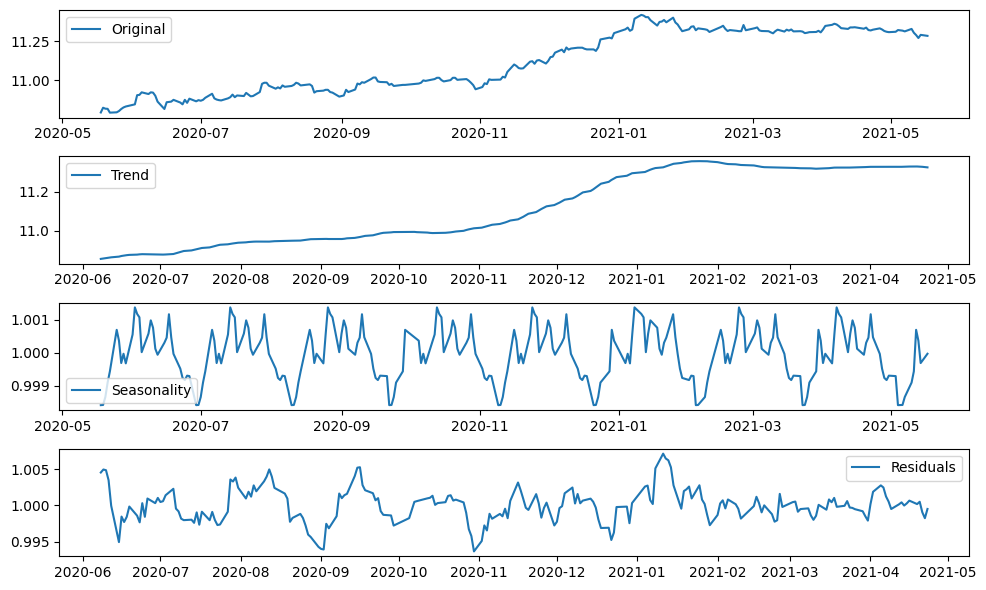

In [22]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (10,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [54]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of ADFTest
Test Statistic                -6.180878e+00
p-value                        6.459861e-08
#Lags Used                     0.000000e+00
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

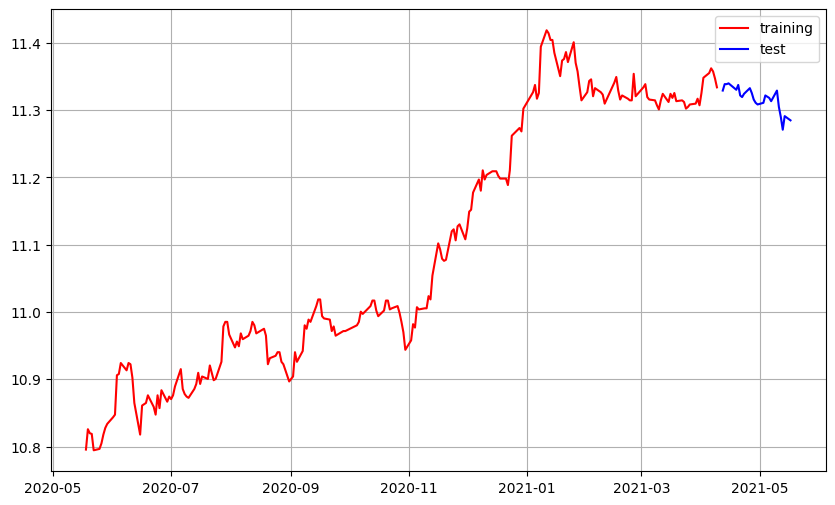

In [55]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test')
plt.legend()

## 5. 적정 ARIMA 모수 찾기(ACF, PACF 그려보기)

c:\Users\Jennie\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


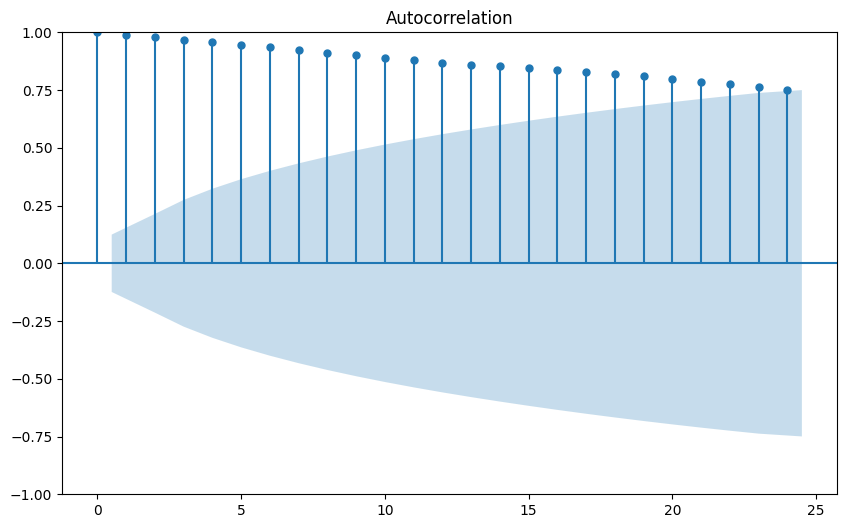

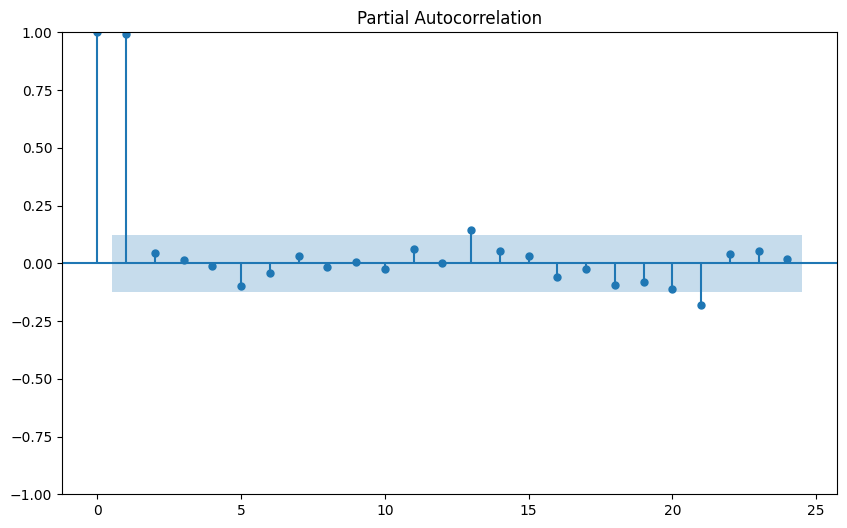

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show() 
# PACF가 2를 기점으로 감소
# p를 2로 해야함!
# p*q=0이니까 q=0

Results of ADFTest
Test Statistic                -1.550157e+01
p-value                        2.411857e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


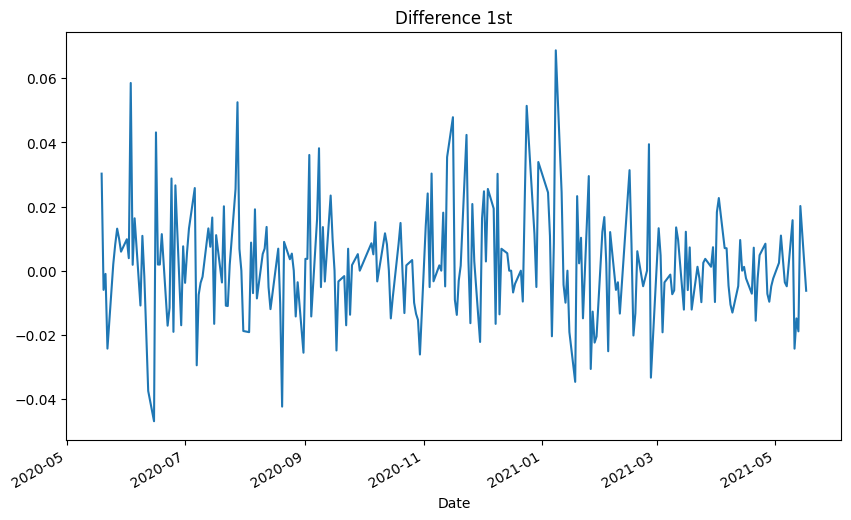

In [74]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [87]:
from statsmodels.tsa.arima.model import ARIMA

# model
model = ARIMA(train_data, order=(2,0,1)) # 그래프를 그려 p=2, q=0으로 지정
fitted_m = model.fit()
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 580.296
Date:                Sat, 12 Nov 2022   AIC                          -1150.592
Time:                        18:02:18   BIC                          -1133.534
Sample:                             0   HQIC                         -1143.707
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0885      0.132     84.218      0.000      10.830      11.347
ar.L1          0.7559      1.829      0.413      0.679      -2.830       4.341
ar.L2          0.2372      1.819      0.130      0.8

c:\Users\Jennie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Jennie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Jennie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 6. ARIMA 모델 훈련과 테스트

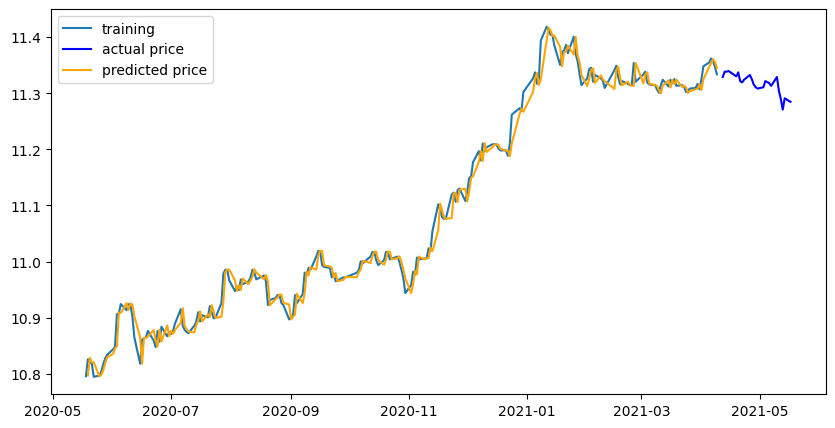

In [85]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fitted_m, c='orange',label='predicted price')
plt.legend()
plt.show()

In [89]:
from statsmodels.tsa.arima.model import ARIMA

# model
model = ARIMA(train_data, order=(2,0,1)) # 그래프를 그려 p=2, q=0으로 지정
fitted_m = model.fit()
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 580.296
Date:                Sat, 12 Nov 2022   AIC                          -1150.592
Time:                        18:04:38   BIC                          -1133.534
Sample:                             0   HQIC                         -1143.707
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0885      0.132     84.218      0.000      10.830      11.347
ar.L1          0.7559      1.829      0.413      0.679      -2.830       4.341
ar.L2          0.2372      1.819      0.130      0.8

c:\Users\Jennie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Jennie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Jennie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [90]:
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  883848.4856202872
MAE:  735.3476386124362
RMSE:  940.1321639111637
MAPE: 0.90%


c:\Users\Jennie\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
